#Accessing Data

[MTA's Subway Major Incidents Dashboard](https://metrics.mta.info/?subway/majorincidents)

Data sources:

[MTA Subway Major Incidents 2015-2019](https://data.ny.gov/Transportation/MTA-Subway-Major-Incidents-2015-2019/ereg-mcvp/about_data)

[MTA Subway Major Incidents 2020-YTD](https://data.ny.gov/Transportation/MTA-Subway-Major-Incidents-Beginning-2020/j6d2-s8m2/about_data)

##Preprocessing
Step 1: Convert dates to datetime format and extract month and year in separate columns.


Next steps:

1) month is not correlated

2) need to bucket counts (preprocess)

3) remove anomalies

4) identify fewer clusters --> make profiles based on clusters to assess strategic MTA interventions


In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import warnings
from google.colab import drive


#warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Key Dataset: Service Disruptions
### Data Source: NYC Open Data Portal
### Dataset: [MTA Subway Major Incidents: Beginning 2020](https://data.ny.gov/Transportation/MTA-Subway-Major-Incidents-Beginning-2020/j6d2-s8m2/about_data)

Major Incidents are incidents that delay 50 or more trains, which cause the most disruption to customers.

**Variables:**

1. month: month in which Major Incidents are being calculated
2. division:  A Division (numbered subway lines) and B Division (lettered subway lines)
3. line: each subway line
4. day_type: weekday or weekend (limited to weekday)
5. category: The six categories that fall under the definition of a Major Incident: Track, Signals, Persons on Trackbed/Police/Medical, Stations and Structure, Subway Car, and Other.
6. count: num of major incidents that occured per month and per subway line

In [ ]:
incidents_path = '/content/drive/MyDrive/AML_Proj/MTA_Subway_Major_Incidents__Beginning_2020_20241107.csv'
incidents_df = pd.read_csv(incidents_path)

incidents_df['month'] = pd.to_datetime(incidents_df['month'])
incidents_df['month_yr'] = incidents_df['month'].dt.to_period('M')
incidents_df = incidents_df[incidents_df['day_type'] == 1]
incidents_df = incidents_df.drop(columns='month')[['month_yr', 'division', 'line', 'day_type', 'category', 'count']]
incidents_df.head()

month_yr    division line  day_type                category  count
0  2024-09  A DIVISION    1         1  Stations and Structure      1
1  2024-09  A DIVISION    1         1                   Track      2
2  2024-09  A DIVISION    1         1                   Other      1
3  2024-09  A DIVISION    1         1                 Signals      1
4  2024-09  A DIVISION    2         1                   Track      2

#  <font color=green> Merging Other Datasets

## Weather Statistics

### Data source: Climate Data Online from National Oceanic and Atmospheric Administration
### Dataset: [Global Summary of the Month](https://www.ncei.noaa.gov/cdo-web/search)

**Variables:**

**Weather impact on disruptions:**

1. AWND: Captures wind effects on service operations.
2. PRCP: Total precipitation, directly linked to potential flooding.
3. SNOW: Total snowfall, important for winter disruptions.
4. DSND: Number of days with significant snow depth.
5. TAVG: Average temperature for general climate impact.
6. TMAX: Monthly maximum temperature for heat-related stress.
7. TMIN: Monthly minimum temperature for cold-related risks.
8. DX90: Number of very hot days (≥ 90°F), which can stress infrastructure.
9. DT32: Number of very cold days (≤ 32°F), which can lead to freezing-related disruptions.

**Key Daily Extremes:**
1. EMXP: Maximum daily precipitation in the month, a proxy for extreme rain events.
2. EMSN: Maximum daily snowfall, useful for peak snow disruptions.
3. EMXT: Extreme max temperature, highlighting heat-related thresholds.
4. EMNT: Extreme min temperature, indicating freezing risks.

In [ ]:
weather_path = '/content/drive/MyDrive/AML_Proj/nyc_weather_2020_2022.csv'
weather_path2 = '/content/drive/MyDrive/AML_Proj/nyc_weather_2022-2024.csv'
weather_df = pd.concat([pd.read_csv(weather_path), pd.read_csv(weather_path2)], axis = 0)

weather_df_preprocessed = weather_df[['STATION', 'DATE', 'AWND', 'PRCP', 'SNOW', 'DSND', 'TAVG', 'TMAX', 'TMIN', 'DX90', 'DT32', 'EMXP', 'EMSN', 'EMXT', 'EMNT']]
weather_df_preprocessed['month_yr'] = pd.to_datetime(weather_df_preprocessed['DATE']).dt.to_period('M')
weather_df_preprocessed = weather_df_preprocessed.dropna()

# Aggregate data by 'month_year'
aggregated_weather = weather_df_preprocessed.groupby('month_yr').agg({
    'AWND': 'mean',  # Average wind speed
    'PRCP': 'sum',   # Total precipitation
    'SNOW': 'sum',   # Total snowfall
    'DSND': 'sum',   # Total snow depth
    'TAVG': 'mean',  # Average temperature
    'TMAX': 'mean',  # Average max temperature
    'TMIN': 'mean',  # Average min temperature
    'DX90': 'sum',   # Total number of very hot days (≥ 90°F)
    'DT32': 'sum',   # Total number of very cold days (≤ 32°F)
    'EMXP': 'max',   # Maximum daily precipitation
    'EMSN': 'max',   # Maximum daily snowfall
    'EMXT': 'max',   # Extreme max temperature
    'EMNT': 'min'    # Extreme min temperature
}).reset_index()

merge_df = pd.merge(incidents_df, aggregated_weather, on='month_yr', how='left')
merge_df.head()

NameError: name 'pd' is not defined

## Mean Distance Between Failures

### Data source: NYC Open Data Portal
### Dataset: [MTA Subway Mean Distance Between Failures: Beginning 2015](https://data.ny.gov/Transportation/MTA-Subway-Mean-Distance-Between-Failures-Beginnin/e2qc-xgxs/about_data)

Mean Distance Between Failures reports how frequently train mechanical problems cause delays by month and subway car class. It is the main indicator for subway car reliability used at NYCT and is used to compare performance over time and across different subway car types. Only a small proportion of subway delays are due to malfunctioning trains.

**Variables:**
1. Number of Failures: Total number of failures recorded on a monly basis per class
2. Number of Cars: total number of subway cars in each car class
3. MDBF: Mean Distance Between Failures on a monthly basis per car class
4. 12-Month Average MDBF: Mean Distance Between Failures for each car class for the past 12 months

In [ ]:
import pandas as pd

mdbf_path = '/content/drive/MyDrive/AML_Proj/MTA_mdbf.csv'
mdbf_df = pd.read_csv(mdbf_path)

# Parse the 'Month' column to datetime
mdbf_df['month_yr'] = pd.to_datetime(mdbf_df['Month'], errors='coerce')

# Create a 'month_year_division' key
mdbf_df['month_yr_division'] = mdbf_df['month_yr'].dt.to_period('M').astype(str) + '-' + mdbf_df['Division']

# Aggregate the data by 'month_year_division'
aggregated_mdbf = mdbf_df.groupby('month_yr_division').agg({
    'Number of Failures': 'sum',
    'Number of Cars': 'sum',
    'MDBF': 'mean',
    '12-Month Average MDBF': 'mean'
}).reset_index()

merge_df['division'] = merge_df['division'].replace({'A DIVISION': 'A', 'B DIVISION': 'B'}) # Standardize the 'division' column in merge_df
merge_df = merge_df[merge_df['division'] != 'Systemwide'] # Drop rows where 'division' is 'Systemwide'

merge_df['month_yr'] = merge_df['month_yr'].astype(str)
merge_df['month_yr_division'] = merge_df['month_yr'].str.strip() + '-' + merge_df['division'].str.strip()

merge_df = pd.merge(
    merge_df,
    aggregated_mdbf,
    on='month_yr_division',
    how='left'
).drop(columns = 'month_yr_division')

merge_df.head()

<ipython-input-6-204ee325dcde>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_df['month_yr'] = merge_df['month_yr'].astype(str)
<ipython-input-6-204ee325dcde>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_df['month_yr_division'] = merge_df['month_yr'].str.strip() + '-' + merge_df['division'].str.strip()


month_yr division line  day_type                category  count  AWND  PRCP  \
0  2024-09        A    1         1  Stations and Structure      1  7.65  4.79   
1  2024-09        A    1         1                   Track      2  7.65  4.79   
2  2024-09        A    1         1                   Other      1  7.65  4.79   
3  2024-09        A    1         1                 Signals      1  7.65  4.79   
4  2024-09        A    2         1                   Track      2  7.65  4.79   

   SNOW  DSND   TAVG    TMAX  TMIN  DX90  DT32  EMXP  EMSN  EMXT  EMNT  \
0   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   
1   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   
2   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   
3   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   
4   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   

   Number of Failures  Number of Cars      MDBF  12-Month Average MDBF  
0               107.0          2890.0  188093.2          188617.833333  
1               107.0          2890.0  188093.2          188617.833333  
2               107.0          2890.0  188093.2          188617.833333  
3               107.0          2890.0  188093.2          188617.833333  
4               107.0          2890.0  188093.2          188617.833333

## MTA Subway Trains Delayed

### Data source: NYC Open Data Portal
### Dataset: [MTA Subway Trains Delayed: Beginning 2020](https://data.ny.gov/Transportation/MTA-Subway-Trains-Delayed-Beginning-2020/wx2t-qtaz/about_data)

This dataset reflects the number and percentage of subway trains delayed per weekday based on scheduled service, broken down into specific delay categories.

**Variables:**
1. delays: The number of train delays per category and month_year.

In [ ]:
delays_path = '/content/drive/MyDrive/AML_Proj/MTA_Subway_Trains_Delayed__Beginning_2020_20241210.csv'
delays_df = pd.read_csv(delays_path)

delays_df['month'] = pd.to_datetime(delays_df['month'])
delays_df['month_year'] = delays_df['month'].dt.to_period('M').astype(str)
delays_df['month_year_line'] = delays_df['month_year'] + '-' + delays_df['line'].astype(str)

# Aggregate delays by 'month_year_line'
delays_aggregated = delays_df.groupby('month_year_line').agg({
    'delays': 'sum'
}).reset_index()

delays_aggregated.rename(columns={'delays': 'sum_of_delays'}, inplace=True)
merge_df['month_year_line'] = merge_df['month_yr'] + '-' + merge_df['line'].astype(str)

# Merge merged_with_mdbf with delays_aggregated on 'month_year_line'
merge_df = pd.merge(
    merge_df,
    delays_aggregated,
    on='month_year_line',
    how='left'
).drop(columns='month_year_line')

merge_df.head()


month_yr division line  day_type                category  count  AWND  PRCP  \
0  2024-09        A    1         1  Stations and Structure      1  7.65  4.79   
1  2024-09        A    1         1                   Track      2  7.65  4.79   
2  2024-09        A    1         1                   Other      1  7.65  4.79   
3  2024-09        A    1         1                 Signals      1  7.65  4.79   
4  2024-09        A    2         1                   Track      2  7.65  4.79   

   SNOW  DSND   TAVG    TMAX  TMIN  DX90  DT32  EMXP  EMSN  EMXT  EMNT  \
0   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   
1   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   
2   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   
3   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   
4   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   

   Number of Failures  Number of Cars      MDBF  12-Month Average MDBF  \
0               107.0          2890.0  188093.2          188617.833333   
1               107.0          2890.0  188093.2          188617.833333   
2               107.0          2890.0  188093.2          188617.833333   
3               107.0          2890.0  188093.2          188617.833333   
4               107.0          2890.0  188093.2          188617.833333   

   sum_of_delays  
0         1927.0  
1         1927.0  
2         1927.0  
3         1927.0  
4         2888.0

## Subway Stops per Line

### Data Source: NYC Open Data Portal
### Dataset: [MTA Subway Entrances and Exits: 2024](https://data.ny.gov/Transportation/MTA-Subway-Entrances-and-Exits-2024/i9wp-a4ja/about_data)

**Variables:**

Num stops that each line services during weekdays (num_stations)

In [ ]:
subway_stops = pd.read_csv('/content/drive/MyDrive/AML_Proj/MTA_Subway_Entrances_and_Exits__2024_20241210.csv')
subway_stops = subway_stops[subway_stops['Entrance Type'] == 'Stair']

exploded_routes = subway_stops.assign(Daytime_Route=subway_stops['Daytime Routes'].str.split()).explode('Daytime_Route')

unique_stations_per_line = exploded_routes[['Daytime_Route', 'Constituent Station Name']].drop_duplicates()

num_stations_per_line = unique_stations_per_line.groupby('Daytime_Route')['Constituent Station Name'].nunique().reset_index()
num_stations_per_line.columns = ['line', 'num_stations']

merge_df = pd.merge(
    merge_df,
    num_stations_per_line,
    on='line',
    how='left'
).drop(columns='line')
merge_df.head()

month_yr division  day_type                category  count  AWND  PRCP  \
0  2024-09        A         1  Stations and Structure      1  7.65  4.79   
1  2024-09        A         1                   Track      2  7.65  4.79   
2  2024-09        A         1                   Other      1  7.65  4.79   
3  2024-09        A         1                 Signals      1  7.65  4.79   
4  2024-09        A         1                   Track      2  7.65  4.79   

   SNOW  DSND   TAVG    TMAX  TMIN  DX90  DT32  EMXP  EMSN  EMXT  EMNT  \
0   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   
1   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   
2   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   
3   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   
4   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   

   Number of Failures  Number of Cars      MDBF  12-Month Average MDBF  \
0               107.0          2890.0  188093.2          188617.833333   
1               107.0          2890.0  188093.2          188617.833333   
2               107.0          2890.0  188093.2          188617.833333   
3               107.0          2890.0  188093.2          188617.833333   
4               107.0          2890.0  188093.2          188617.833333   

   sum_of_delays  num_stations  
0         1927.0          39.0  
1         1927.0          39.0  
2         1927.0          39.0  
3         1927.0          39.0  
4         2888.0          51.0

## Monthly Ridership per Subway Line

### Data Source: NYC Open Data Portal
### Dataset: [MTA Subway Hourly Ridership: Beginning July 2020](https://data.ny.gov/Transportation/MTA-Subway-Hourly-Ridership-Beginning-July-2020/wujg-7c2s/about_data)

**Key Assumption:** If multiple lines stopped at a subway station, we assume **uniform** ridership across all lines. In other words, we divide aggregate ridership by num lines stopped at subway station.

**Variables:**

1. total_ridership: total_ridership by month_year and line

In [ ]:
# Run once
'''
import pandas as pd
import zipfile

zip_file_path = "/content/drive/MyDrive/AML_Proj/MTA_Subway_Hourly_Ridership__Beginning_July_2020_20241210.csv.zip"
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.printdir()
    zip_ref.extractall("extracted_files")
    file_to_load = [f for f in zip_ref.namelist() if f.endswith('.csv')][0]

csv_file_path = f"/extracted_files/{file_to_load}"

csv_file_path = "/content/drive/MyDrive/AML_Proj/MTA_Subway_Hourly_Ridership__Beginning_July_2020_20241210.csv"

chunks = []
chunk_size = 5*10**6  #[total rows 105476426]

columns_needed = ['transit_timestamp', 'station_complex_id', 'station_complex', 'ridership']
for chunk in pd.read_csv(csv_file_path, usecols=columns_needed, chunksize=chunk_size, on_bad_lines='skip', engine='python'):
    chunks.append(chunk)

ridership_df = pd.concat(chunks, ignore_index=True)
ridership_df.head()


import pandas as pd

ridership_df = pd.read_csv('/content/drive/MyDrive/AML_Proj/ridership.csv')
ridership_df['month_yr'] = pd.to_datetime(ridership_df['transit_timestamp']).dt.to_period('M')

# Extract the bracketed values from 'station_complex' into a new column
ridership_df['lines'] = ridership_df['station_complex'].str.extract(r'\(([^)]+)\)$')
ridership_df['lines'] = ridership_df['lines'].str.split(',')

# Step 3: Explode the DataFrame by 'lines'
exploded_df = ridership_df.explode('lines')
exploded_df['lines'] = exploded_df['lines'].str.strip()
exploded_df = exploded_df.reset_index(drop=True)

#Count the number of lines for each station_complex and divide ridership by the number of lines
exploded_df['num_lines'] = exploded_df.groupby(['station_complex', 'transit_timestamp'])['lines'].transform('count')
exploded_df['adjusted_ridership'] = exploded_df['ridership'] / exploded_df['num_lines']
exploded_df['transit_timestamp'] = pd.to_datetime(exploded_df['transit_timestamp'])
exploded_df['month_year'] = exploded_df['transit_timestamp'].dt.to_period('M')

monthly_ridership = exploded_df.groupby(['month_year', 'lines'])['adjusted_ridership'].sum().reset_index()

# Step 4: Rename columns for clarity
monthly_ridership.columns = ['month_year', 'line', 'total_ridership']
monthly_ridership.head(20)
''';

In [ ]:
ridership_df = pd.read_csv('/content/drive/MyDrive/AML_Proj/mta_ridership.csv')
ridership_df['date'] = pd.to_datetime(ridership_df['date'], errors='coerce')
ridership_df['month_yr'] = ridership_df['date'].dt.to_period('M')
ridership_df = ridership_df.groupby('month_yr').agg({'ridership': 'sum'}).reset_index()

merge_df['month_yr'] = merge_df['month_yr'].astype(str)
ridership_df['month_yr'] = ridership_df['month_yr'].astype(str)

# Merge the DataFrames
merge_df = pd.merge(
    merge_df,
    ridership_df,
    on='month_yr',
    how='left'
)
merge_df.head()

<ipython-input-10-2d123b40985a>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ridership_df['date'] = pd.to_datetime(ridership_df['date'], errors='coerce')


month_yr division  day_type                category  count  AWND  PRCP  \
0  2024-09        A         1  Stations and Structure      1  7.65  4.79   
1  2024-09        A         1                   Track      2  7.65  4.79   
2  2024-09        A         1                   Other      1  7.65  4.79   
3  2024-09        A         1                 Signals      1  7.65  4.79   
4  2024-09        A         1                   Track      2  7.65  4.79   

   SNOW  DSND   TAVG    TMAX  TMIN  DX90  DT32  EMXP  EMSN  EMXT  EMNT  \
0   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   
1   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   
2   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   
3   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   
4   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   

   Number of Failures  Number of Cars      MDBF  12-Month Average MDBF  \
0               107.0          2890.0  188093.2          188617.833333   
1               107.0          2890.0  188093.2          188617.833333   
2               107.0          2890.0  188093.2          188617.833333   
3               107.0          2890.0  188093.2          188617.833333   
4               107.0          2890.0  188093.2          188617.833333   

   sum_of_delays  num_stations    ridership  
0         1927.0          39.0  103578757.0  
1         1927.0          39.0  103578757.0  
2         1927.0          39.0  103578757.0  
3         1927.0          39.0  103578757.0  
4         2888.0          51.0  103578757.0

In [ ]:
merge_df['month_yr'] = pd.to_datetime(merge_df['month_yr'], format='%Y-%m')
merge_df['month_yr'] = merge_df['month_yr'].dt.to_period('M')
merge_df.head()

month_yr division  day_type                category  count  AWND  PRCP  \
0  2024-09        A         1  Stations and Structure      1  7.65  4.79   
1  2024-09        A         1                   Track      2  7.65  4.79   
2  2024-09        A         1                   Other      1  7.65  4.79   
3  2024-09        A         1                 Signals      1  7.65  4.79   
4  2024-09        A         1                   Track      2  7.65  4.79   

   SNOW  DSND   TAVG    TMAX  TMIN  DX90  DT32  EMXP  EMSN  EMXT  EMNT  \
0   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   
1   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   
2   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   
3   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   
4   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   

   Number of Failures  Number of Cars      MDBF  12-Month Average MDBF  \
0               107.0          2890.0  188093.2          188617.833333   
1               107.0          2890.0  188093.2          188617.833333   
2               107.0          2890.0  188093.2          188617.833333   
3               107.0          2890.0  188093.2          188617.833333   
4               107.0          2890.0  188093.2          188617.833333   

   sum_of_delays  num_stations    ridership  
0         1927.0          39.0  103578757.0  
1         1927.0          39.0  103578757.0  
2         1927.0          39.0  103578757.0  
3         1927.0          39.0  103578757.0  
4         2888.0          51.0  103578757.0

# <font color=green> Data Exploration



In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

df_pre_2020 = pd.read_csv('/MTA_Subway_Major_Incidents__2015-2019_20241107.csv')
df_post_2020 = pd.read_csv('/MTA_Subway_Major_Incidents__Beginning_2020_20241107.csv')

df = pd.concat([df_pre_2020, df_post_2020])
df_preprocess = df.copy()

df_preprocess['date'] = pd.to_datetime(df_preprocess['month'])
df_preprocess = df_preprocess.sort_values(by='date')

#Extracting month and year
df_preprocess['year'] = df_preprocess['date'].dt.year
df_preprocess['month'] = df_preprocess['date'].dt.month
df_preprocess.head()

month    division line  day_type                            category  \
0       1  A DIVISION    1         1                             Signals   
35      1  B DIVISION    C         1  Persons on Trackbed/Police/Medical   
36      1  B DIVISION    C         1                             Signals   
37      1  B DIVISION    D         1  Persons on Trackbed/Police/Medical   
38      1  B DIVISION    D         2                             Signals   

    count       date  year  
0       1 2015-01-01  2015  
35      1 2015-01-01  2015  
36      1 2015-01-01  2015  
37      1 2015-01-01  2015  
38      1 2015-01-01  2015

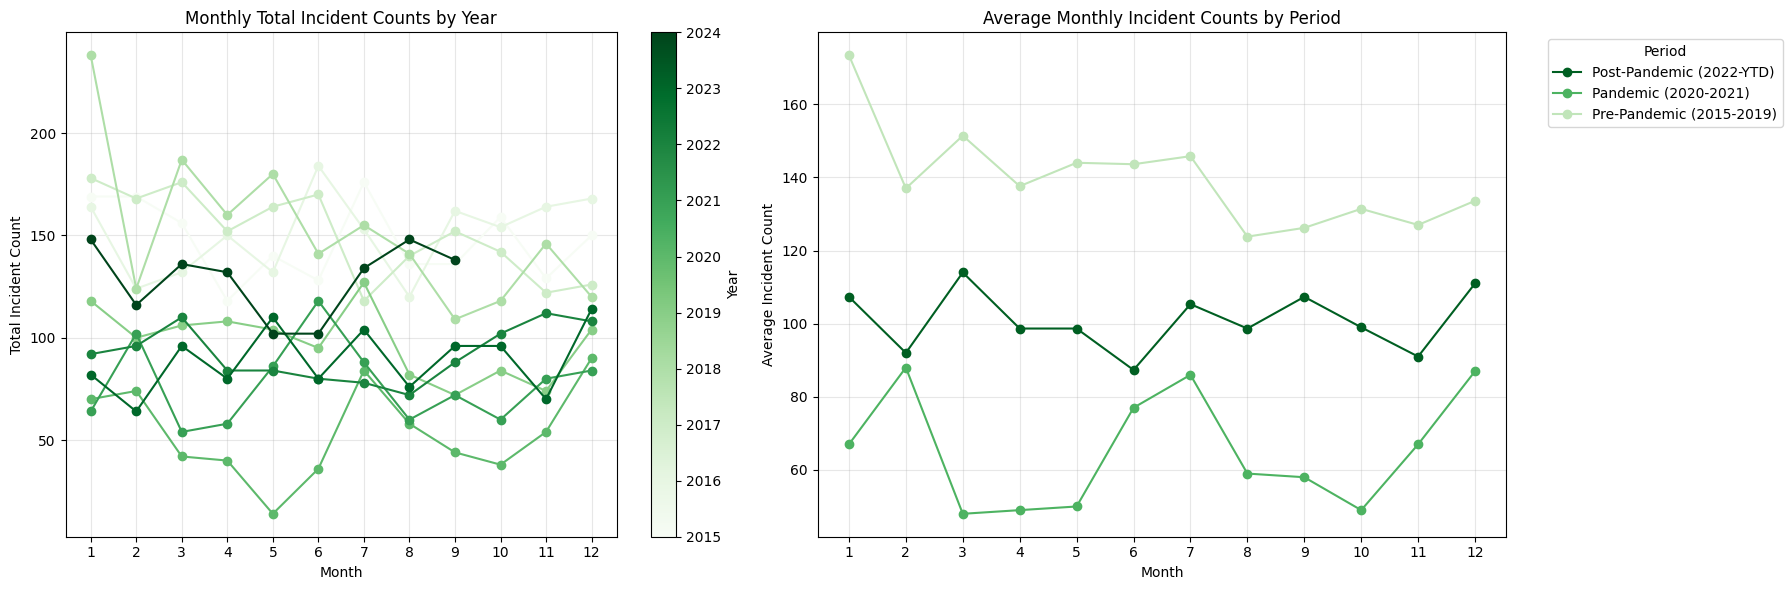

In [ ]:
monthly_totals = df_preprocess.groupby(['year', 'month'])['count'].sum().reset_index()
monthly_totals = monthly_totals.sort_values(['year', 'month'])

def categorize_period(year):
    if year < 2020:
        return 'Pre-Pandemic (2015-2019)'
    elif year == 2020:
        return 'Pandemic (2020-2021)'
    elif 2020 < year <= 2021:
        return 'Pandemic (2020-2021)'
    else:
        return 'Post-Pandemic (2022-YTD)'


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

cmap = cm.Greens
norm = plt.Normalize(vmin=monthly_totals['year'].min(), vmax=monthly_totals['year'].max())

for year in sorted(monthly_totals['year'].unique()):
    year_data = monthly_totals[monthly_totals['year'] == year]
    ax1.plot(year_data['month'], year_data['count'], marker='o',
             color=cmap(norm(year)))

ax1.set_title('Monthly Total Incident Counts by Year')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Incident Count')
ax1.set_xticks(range(1, 13))
ax1.grid(True, alpha=0.3)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax1, label='Year')

monthly_totals['period'] = monthly_totals['year'].apply(categorize_period)
period_avg = monthly_totals.groupby(['month', 'period'])['count'].mean().unstack()

color_map = {
    'Pre-Pandemic (2015-2019)': '#c1e5ba',
    'Pandemic (2020-2021)': '#4db361',
    'Post-Pandemic (2022-YTD)': '#005f22'
}

for period in period_avg.columns:
    ax2.plot(period_avg.index, period_avg[period], marker='o', label=period, color=color_map[period])

ax2.set_title('Average Monthly Incident Counts by Period')
ax2.set_xlabel('Month')
ax2.set_ylabel('Average Incident Count')
ax2.set_xticks(range(1, 13))
ax2.grid(True, alpha=0.3)


handles, labels = ax2.get_legend_handles_labels()
order = ['Post-Pandemic (2022-YTD)', 'Pandemic (2020-2021)','Pre-Pandemic (2015-2019)' ]
ax2.legend([handles[labels.index(o)] for o in order], order, title='Period', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


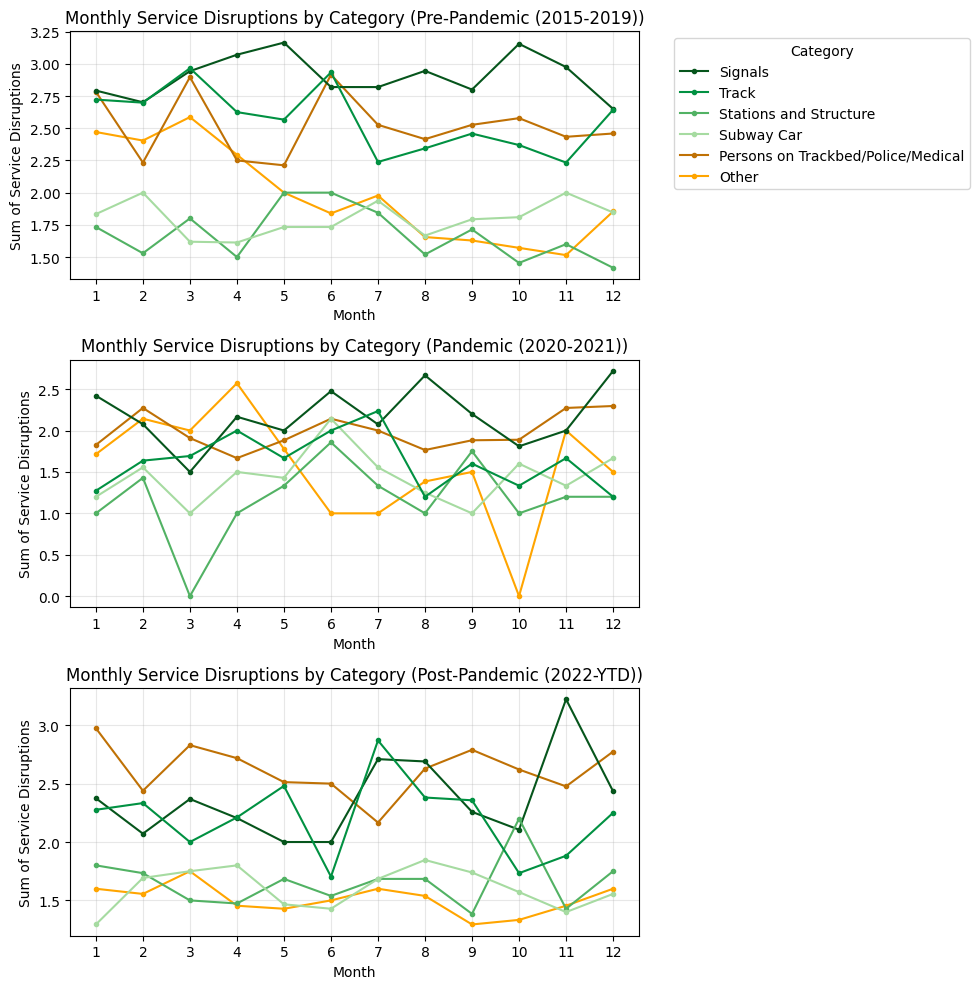

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

df_preprocess['period'] = df_preprocess['year'].apply(categorize_period)
monthly_service_totals = df_preprocess.groupby(['month', 'period', 'category'])['count'].mean().reset_index()

df_pre_pandemic = monthly_service_totals[monthly_service_totals['period'] == 'Pre-Pandemic (2015-2019)']
df_pandemic = monthly_service_totals[monthly_service_totals['period'] == 'Pandemic (2020-2021)']
df_post_pandemic = monthly_service_totals[monthly_service_totals['period'] == 'Post-Pandemic (2022-YTD)']


def plot_service_disruptions(df, period_name, ax):
    monthly_category_sum = df.groupby(['month', 'category'])['count'].mean().unstack().fillna(0)
    color_palette = {
        'Persons on Trackbed/Police/Medical': '#bf7105',
        'Signals': '#06551c',
        'Track': '#019142',
        'Stations and Structure': '#52b264',
        'Subway Car': '#a6dba1',
        'Other': 'orange'
    }

    for category in monthly_category_sum.columns:
        monthly_category_sum[category].plot(kind='line', marker='o', ax=ax, markersize=3, color=color_palette.get(category, 'black'))

    ax.set_title(f'Monthly Service Disruptions by Category ({period_name})')
    ax.set_xlabel('Month')
    ax.set_ylabel('Sum of Service Disruptions')

    ax.set_xticks(range(1, 13))
    ax.grid(True, alpha=0.3)

    custom_order = ['Signals', 'Track', 'Stations and Structure', 'Subway Car', 'Persons on Trackbed/Police/Medical', 'Other']
    handles, labels = ax.get_legend_handles_labels()
    sorted_handles = [handles[labels.index(c)] for c in custom_order if c in labels]
    sorted_labels = [c for c in custom_order if c in labels]

    if period_name == 'Pre-Pandemic (2015-2019)':
        ax.legend(sorted_handles, sorted_labels, title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        if ax.get_legend() is not None:
            ax.get_legend().remove()

plot_service_disruptions(df_pre_pandemic, 'Pre-Pandemic (2015-2019)', axes[0])
plot_service_disruptions(df_pandemic, 'Pandemic (2020-2021)', axes[1])
plot_service_disruptions(df_post_pandemic, 'Post-Pandemic (2022-YTD)', axes[2])

plt.tight_layout()
plt.show()

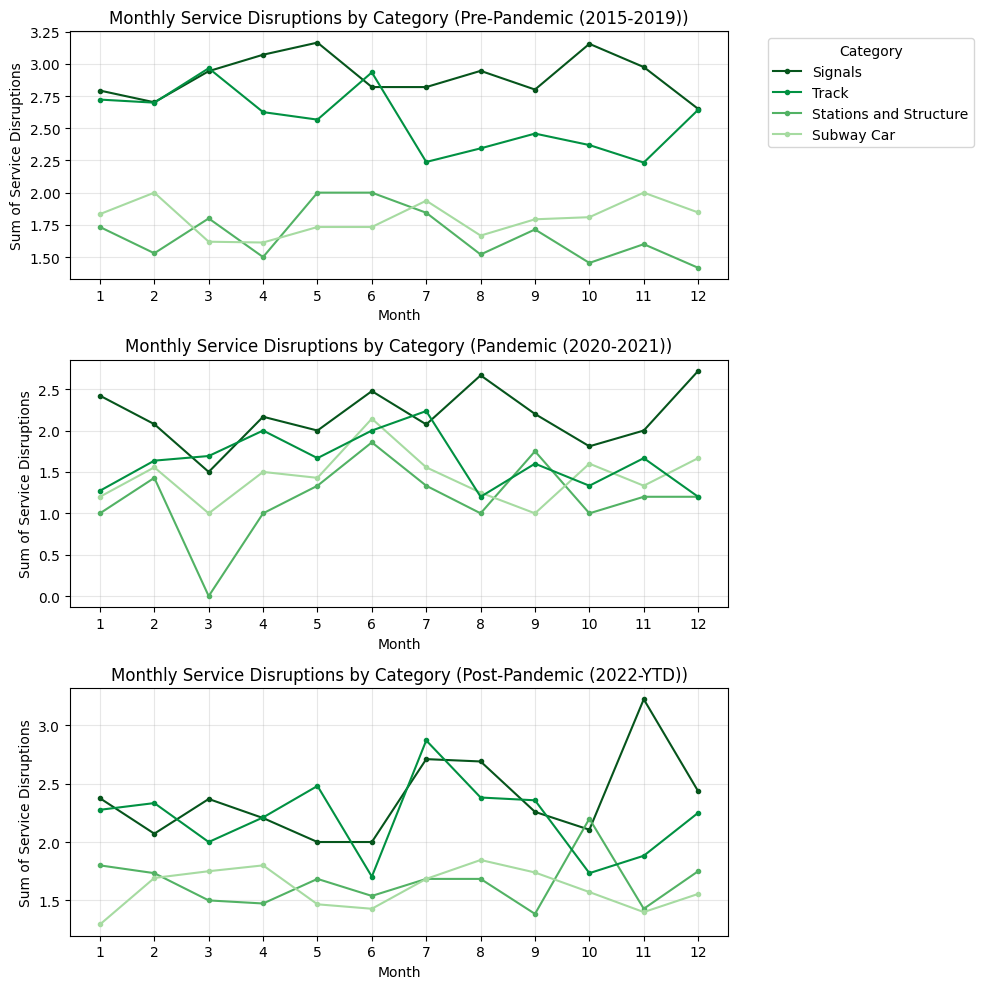

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

monthly_service_totals_xOther = monthly_service_totals[monthly_service_totals['category'].isin(['Signals', 'Track', 'Stations and Structure', 'Subway Car'])]

df_pre_pandemic = monthly_service_totals_xOther[monthly_service_totals_xOther['period'] == 'Pre-Pandemic (2015-2019)']
df_pandemic = monthly_service_totals_xOther[monthly_service_totals_xOther['period'] == 'Pandemic (2020-2021)']
df_post_pandemic = monthly_service_totals_xOther[monthly_service_totals_xOther['period'] == 'Post-Pandemic (2022-YTD)']

# Plot the three periods side by side
plot_service_disruptions(df_pre_pandemic, 'Pre-Pandemic (2015-2019)', axes[0])
plot_service_disruptions(df_pandemic, 'Pandemic (2020-2021)', axes[1])
plot_service_disruptions(df_post_pandemic, 'Post-Pandemic (2022-YTD)', axes[2])

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plots
plt.show()

Summary Statistics:
       day_type        count         AWND         PRCP         SNOW  \
count    1627.0  1627.000000  1627.000000  1627.000000  1627.000000   
mean        1.0     1.341119     8.957126    16.740879     5.349723   
std         0.0     0.665287     1.233306     9.396047    17.789483   
min         1.0     1.000000     6.950000     3.500000     0.000000   
25%         1.0     1.000000     7.775000    10.000000     0.000000   
50%         1.0     1.000000     8.680000    15.030000     0.000000   
75%         1.0     2.000000    10.225000    22.460000     0.100000   
max         1.0     5.000000    11.466667    48.340000   106.100000   

              DSND         TAVG         TMAX         TMIN         DX90  \
count  1627.000000  1627.000000  1627.000000  1627.000000  1627.000000   
mean      4.237246    58.135345    65.549142    50.727282     8.459127   
std      14.556046    15.290461    15.744935    14.885698    14.546360   
min       0.000000    30.325000    37.575000

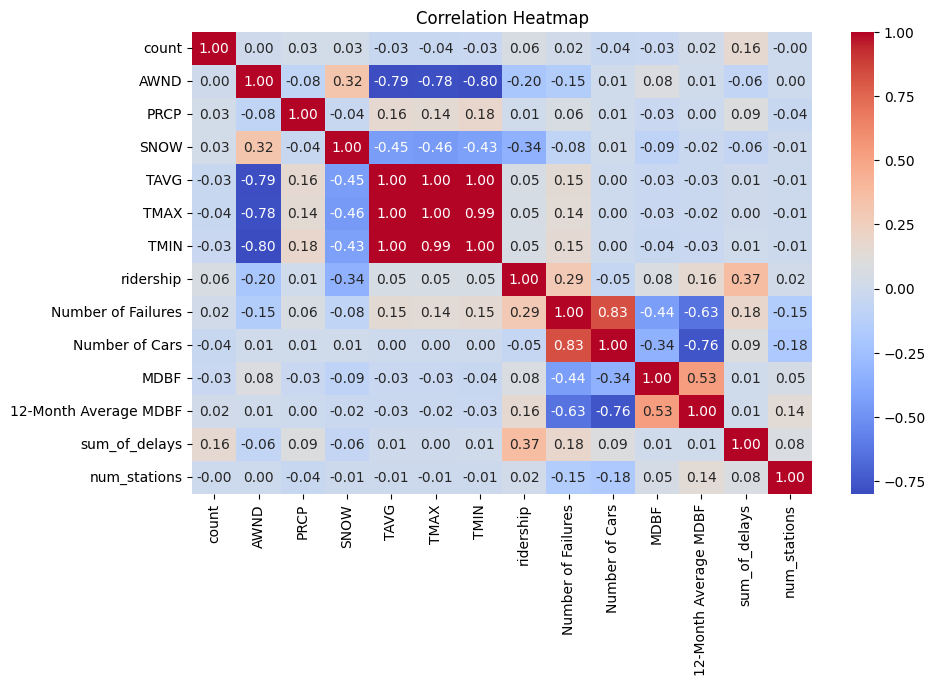

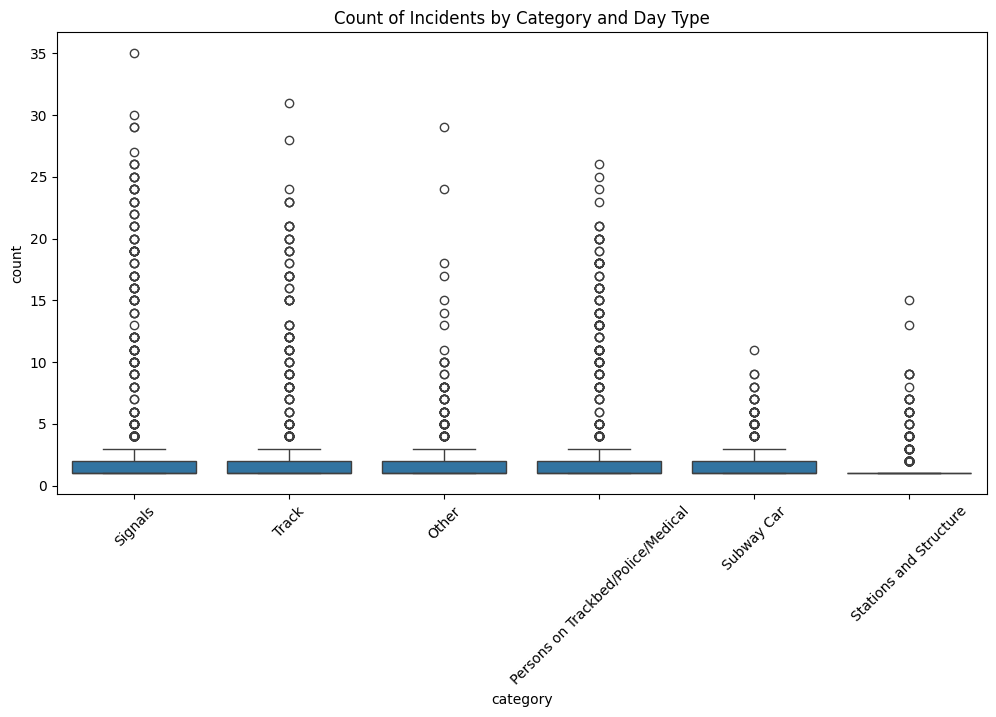

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is called `df`
# General summary statistics
print("Summary Statistics:")
print(merge_df.describe())

# Correlation matrix
print("Correlation Matrix:")
correlation_matrix = merge_df[['count', 'AWND', 'PRCP', 'SNOW', 'TAVG', 'TMAX', 'TMIN', 'ridership', 'Number of Failures', 'Number of Cars', 'MDBF', '12-Month Average MDBF', 'sum_of_delays', 'num_stations']].corr()
print(correlation_matrix)

# Plot correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Ridership vs. Count of Incidents by Category
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='category', y='count')
plt.title("Count of Incidents by Category and Day Type")
plt.xticks(rotation=45)
plt.show()

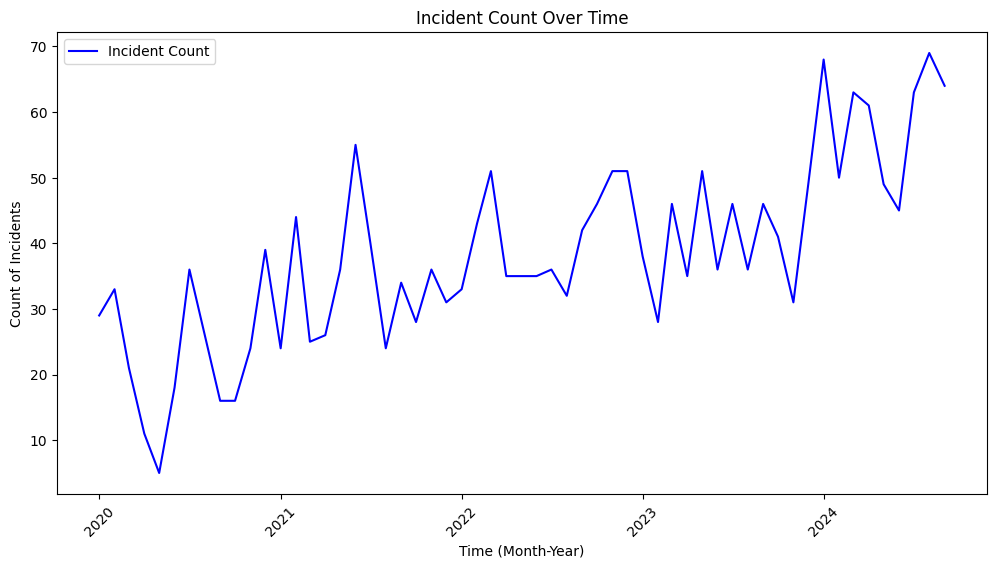

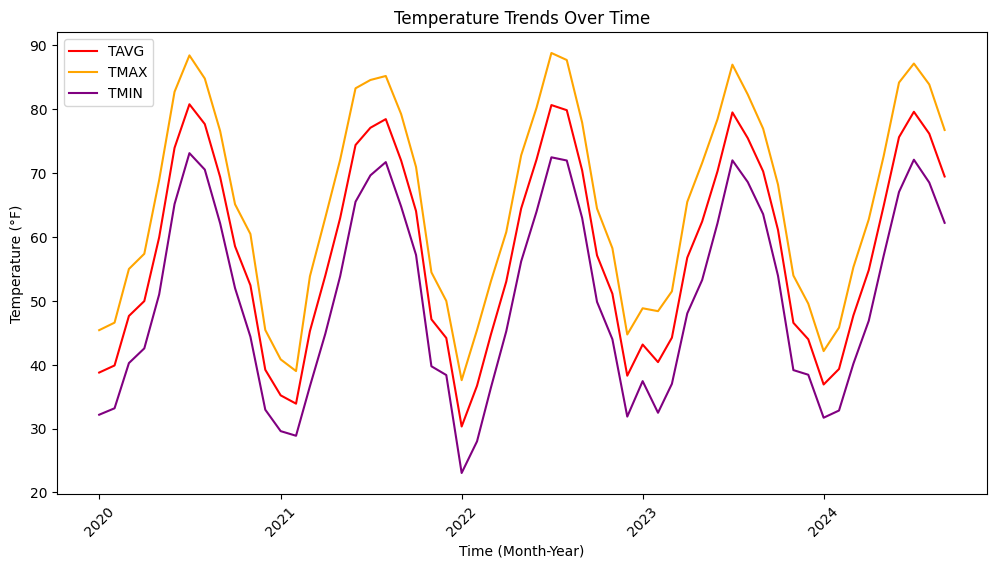

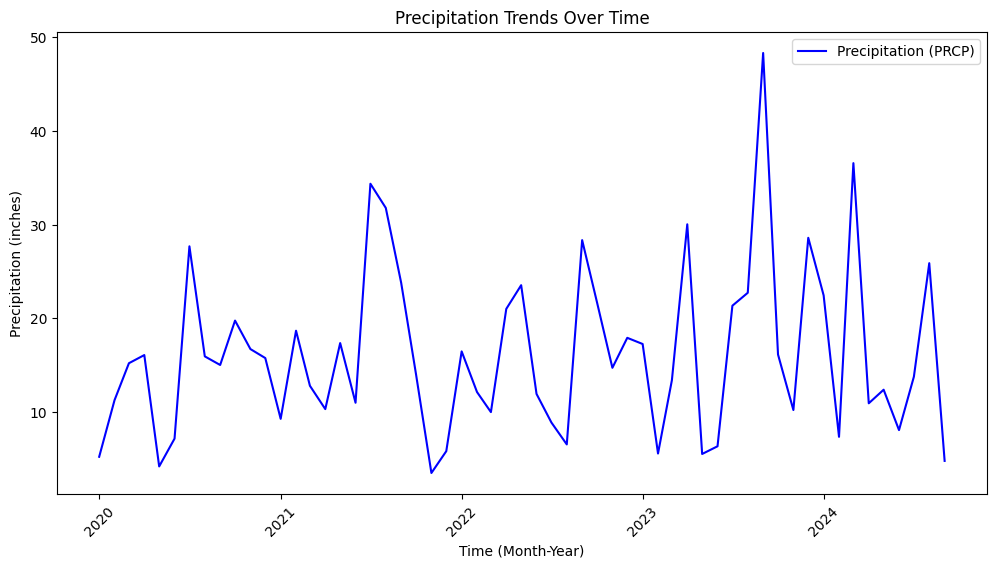

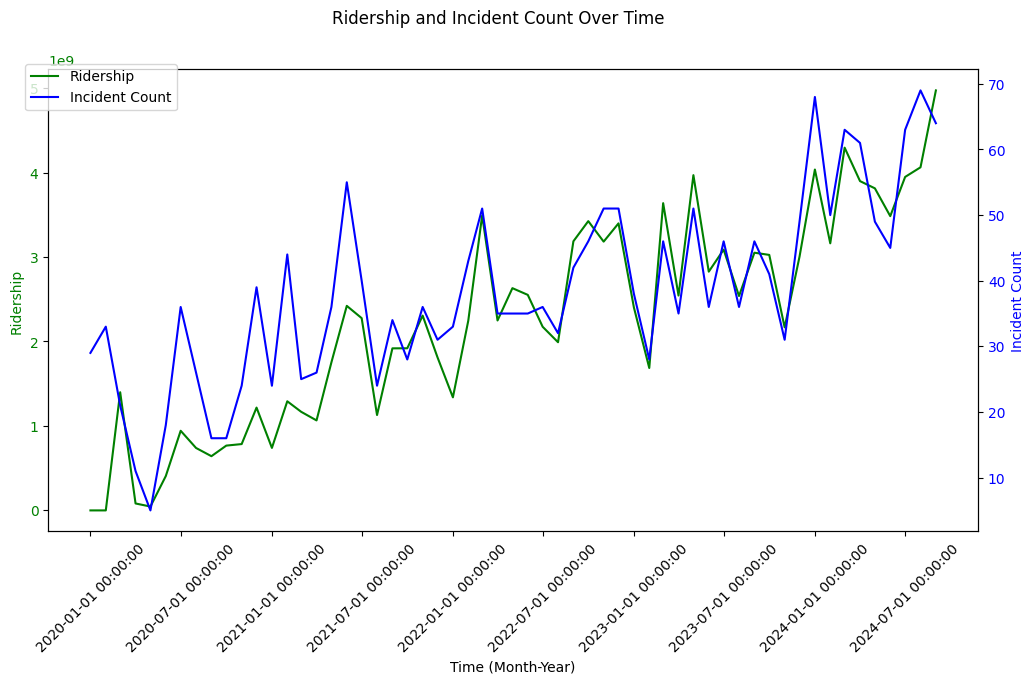

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your DataFrame is called `df`

# Group data by month_yr and calculate averages
time_grouped = merge_df.groupby('month_yr').agg({
    'count': 'sum',
    'AWND': 'mean',
    'PRCP': 'mean',
    'SNOW': 'mean',
    'TAVG': 'mean',
    'TMAX': 'mean',
    'TMIN': 'mean',
    'ridership': 'sum'
}).reset_index()

# Convert month_yr to datetime for proper sorting
time_grouped['month_yr'] = time_grouped['month_yr'].dt.to_timestamp()

# Plot incident count over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=time_grouped, x='month_yr', y='count', label='Incident Count', color='blue')
plt.title("Incident Count Over Time")
plt.xlabel("Time (Month-Year)")
plt.ylabel("Count of Incidents")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Plot temperature trends over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=time_grouped, x='month_yr', y='TAVG', label='TAVG', color='red')
sns.lineplot(data=time_grouped, x='month_yr', y='TMAX', label='TMAX', color='orange')
sns.lineplot(data=time_grouped, x='month_yr', y='TMIN', label='TMIN', color='purple')
plt.title("Temperature Trends Over Time")
plt.xlabel("Time (Month-Year)")
plt.ylabel("Temperature (°F)")
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Plot precipitation trends over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=time_grouped, x='month_yr', y='PRCP', label='Precipitation (PRCP)', color='blue')
plt.title("Precipitation Trends Over Time")
plt.xlabel("Time (Month-Year)")
plt.ylabel("Precipitation (inches)")
plt.xticks(rotation=45)
plt.legend()
plt.show()

import matplotlib.pyplot as plt

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot ridership on the primary y-axis
ax1.plot(time_grouped['month_yr'], time_grouped['ridership'], label='Ridership', color='green')
ax1.set_xlabel("Time (Month-Year)")
ax1.set_ylabel("Ridership", color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_xticks(time_grouped['month_yr'][::6])  # Show every 6 months for readability
ax1.set_xticklabels(time_grouped['month_yr'][::6], rotation=45)

# Create secondary y-axis for incident count
ax2 = ax1.twinx()
ax2.plot(time_grouped['month_yr'], time_grouped['count'], label='Incident Count', color='blue')
ax2.set_ylabel("Incident Count", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Add a title and legends
fig.suptitle("Ridership and Incident Count Over Time")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.show()

# <font color=green> Feature Engineering

In [ ]:
# Temperature range
df = merge_df.copy()
df['temp_range'] = df['TMAX'] - df['TMIN']

# High wind impact (e.g., AWND > 15 mph is high)
df['high_wind'] = (df['AWND'] > 15).astype(int)

# Precipitation intensity categories
df['precipitation_intensity'] = pd.cut(df['PRCP'], bins=[0, 0.1, 0.5, 1, float('inf')],
                                       labels=['None', 'Light', 'Moderate', 'Heavy'])


# Incidents per station
df['incidents_per_station'] = df['count'] / df['num_stations']

# Incidents per train car
df['incidents_per_car'] = df['count'] / df['Number of Cars']

# Delays per incident
df['delays_per_incident'] = df['sum_of_delays'] / df['count']


# Extract month and year
df['month_yr'] = df['month_yr'].dt.to_timestamp()

# Extract month and year from timestamp
df['month'] = df['month_yr'].dt.month
df['year'] = df['month_yr'].dt.year

# Add season (Winter: Dec-Feb, Spring: Mar-May, etc.)
df['season'] = df['month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else
                                              'Spring' if x in [3, 4, 5] else
                                              'Summer' if x in [6, 7, 8] else
                                              'Fall')

# Lagged features (e.g., previous month's ridership)
df['ridership_lag_1'] = df['ridership'].shift(1)
df['incident_count_lag_1'] = df['count'].shift(1)

# Weather impact on ridership
df['ridership_temp_impact'] = df['ridership'] * df['TAVG']
df['ridership_precip_impact'] = df['ridership'] * df['PRCP']

# Delays and weather interaction
df['delays_wind_impact'] = df['sum_of_delays'] * df['AWND']
df['delays_precip_impact'] = df['sum_of_delays'] * df['PRCP']

from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np

# Log transformation for skewed variables
df['log_sum_of_delays'] = np.log1p(df['sum_of_delays'])

# Min-Max scaling
scaler = MinMaxScaler()
df[['ridership_scaled', 'PRCP_scaled']] = scaler.fit_transform(df[['ridership', 'PRCP']])

# Z-score normalization
scaler = StandardScaler()
df[['ridership_normalized', 'AWND_normalized']] = scaler.fit_transform(df[['ridership', 'AWND']])


In [ ]:
df.head()

month_yr division  day_type                category  count  AWND  PRCP  \
0 2024-09-01        A         1  Stations and Structure      1  7.65  4.79   
1 2024-09-01        A         1                   Track      2  7.65  4.79   
2 2024-09-01        A         1                   Other      1  7.65  4.79   
3 2024-09-01        A         1                 Signals      1  7.65  4.79   
4 2024-09-01        A         1                   Track      2  7.65  4.79   

   SNOW  DSND   TAVG    TMAX  TMIN  DX90  DT32  EMXP  EMSN  EMXT  EMNT  \
0   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   
1   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   
2   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   
3   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   
4   0.0   0.0  69.45  76.725  62.2   0.0   0.0  0.78   0.0  87.0  51.0   

   Number of Failures  Number of Cars      MDBF  12-Month Average MDBF  \
0               107.0          2890.0  188093.2          188617.833333   
1               107.0          2890.0  188093.2          188617.833333   
2               107.0          2890.0  188093.2          188617.833333   
3               107.0          2890.0  188093.2          188617.833333   
4               107.0          2890.0  188093.2          188617.833333   

   sum_of_delays  num_stations    ridership  temp_range  high_wind  \
0         1927.0          39.0  103578757.0      14.525          0   
1         1927.0          39.0  103578757.0      14.525          0   
2         1927.0          39.0  103578757.0      14.525          0   
3         1927.0          39.0  103578757.0      14.525          0   
4         2888.0          51.0  103578757.0      14.525          0   

  precipitation_intensity  incidents_per_station  incidents_per_car  \
0                   Heavy               0.025641           0.000346   
1                   Heavy               0.051282           0.000692   
2                   Heavy               0.025641           0.000346   
3                   Heavy               0.025641           0.000346   
4                   Heavy               0.039216           0.000692   

   delays_per_incident  month  year season  ridership_lag_1  \
0               1927.0      9  2024   Fall              NaN   
1                963.5      9  2024   Fall      103578757.0   
2               1927.0      9  2024   Fall      103578757.0   
3               1927.0      9  2024   Fall      103578757.0   
4               1444.0      9  2024   Fall      103578757.0   

   incident_count_lag_1  ridership_temp_impact  ridership_precip_impact  \
0                   NaN           7.193545e+09             4.961422e+08   
1                   1.0           7.193545e+09             4.961422e+08   
2                   2.0           7.193545e+09             4.961422e+08   
3                   1.0           7.193545e+09             4.961422e+08   
4                   1.0           7.193545e+09             4.961422e+08   

   delays_wind_impact  delays_precip_impact  log_sum_of_delays  \
0            14741.55               9230.33           7.564238   
1            14741.55               9230.33           7.564238   
2            14741.55               9230.33           7.564238   
3            14741.55               9230.33           7.564238   
4            22093.20              13833.52           7.968666   

   ridership_scaled  PRCP_scaled  ridership_normalized  AWND_normalized  
0          0.975317     0.028769               1.04657        -1.060181  
1          0.975317     0.028769               1.04657        -1.060181  
2          0.975317     0.028769               1.04657        -1.060181  
3          0.975317     0.028769               1.04657        -1.060181  
4          0.975317     0.028769               1.04657        -1.060181

In [ ]:
preprocess_data = df[['month_yr', 'category', 'temp_range', 'high_wind', 'precipitation_intensity', 'incidents_per_station', 'incidents_per_car', 'delays_per_incident', 'season']]
preprocess_data.head()

month_yr                category  temp_range  high_wind  \
0 2024-09-01  Stations and Structure      14.525          0   
1 2024-09-01                   Track      14.525          0   
2 2024-09-01                   Other      14.525          0   
3 2024-09-01                 Signals      14.525          0   
4 2024-09-01                   Track      14.525          0   

  precipitation_intensity  incidents_per_station  incidents_per_car  \
0                   Heavy               0.025641           0.000346   
1                   Heavy               0.051282           0.000692   
2                   Heavy               0.025641           0.000346   
3                   Heavy               0.025641           0.000346   
4                   Heavy               0.039216           0.000692   

   delays_per_incident season  
0               1927.0   Fall  
1                963.5   Fall  
2               1927.0   Fall  
3               1927.0   Fall  
4               1444.0   Fall

#Clustering


Key Points of Interpretation:
PCA Components:

The x-axis (PCA Component 1) and y-axis (PCA Component 2) are the two principal components derived from PCA.
These components are a transformation of the original features into a lower-dimensional space, summarizing the variance in the data. The goal is to visualize the data in two dimensions while preserving as much of the variance as possible.

Cluster Separation:Each color represents a different cluster identified by the KMeans algorithm with k=27.
Distinct Clusters: The different colors and well-separated clusters indicate that the data has been segmented into distinct groups. For example, clusters that are clearly separated from others (e.g., Cluster 17 or Cluster 26) indicate that the data points in these clusters share distinct characteristics that set them apart from other clusters.
Overlapping Clusters: In some areas, clusters appear closer together or overlapping. This suggests that the points in these clusters are less distinct, possibly due to shared features or a lack of strong separation among the data points.


Interpretation of the Clusters:

Different Patterns: Clusters that are separated along PCA Component 1 or Component 2 imply differences along those key directions of variance. For example, clusters spread horizontally (along the x-axis) likely have different feature values contributing to PCA Component 1.
Tight Grouping: Some clusters are densely packed, meaning the data points in those clusters have very similar values. On the other hand, clusters that are more spread out suggest higher variability among the points within that cluster.
Insights for Service Disruptions:

Since this clustering was performed on data related to service disruptions (including features like line, day_type, category, and year), these clusters could represent different patterns of service disruptions. For example:
One cluster might represent disruptions that predominantly happen on weekdays, another on weekends.
Some clusters may indicate disruptions that are more frequent on specific subway lines or during certain years.
Distinct clusters might highlight specific combinations of line and category that lead to more unique disruption patterns.
Utility of Clustering:

The clusters can be analyzed further to understand the common characteristics of each group. For example, you could look at the original data points in each cluster to see if certain categories of disruptions are more prevalent in certain clusters.
If you see certain clusters that are isolated, it could mean these are anomalous patterns in your data that may require attention (e.g., a certain subway line that has very different disruption patterns compared to others).
Next Steps for Analysis:
Cluster Profiling:

Profile Each Cluster: Investigate the underlying features that make up each cluster. For example, look at the category, line, and day_type values to understand what defines each cluster.
Summarize Characteristics: You could create summary statistics (e.g., means or modes of features) for each cluster to identify defining characteristics.
Domain Insights:

Operational Impact: If certain clusters represent more severe or frequent disruptions, you could use this information to make operational decisions about managing these service disruptions.

Targeted Interventions: For example, if you identify that specific clusters are associated with weekend track disruptions, targeted interventions could be designed to address these patterns.
Further Visualization:

Use box plots or bar charts to analyze feature distributions within each cluster to better understand the defining attributes of the clusters.
Geographical Analysis: If available, you could also plot these clusters on a map to see if there are geographical patterns (e.g., certain lines that have more disruptions).

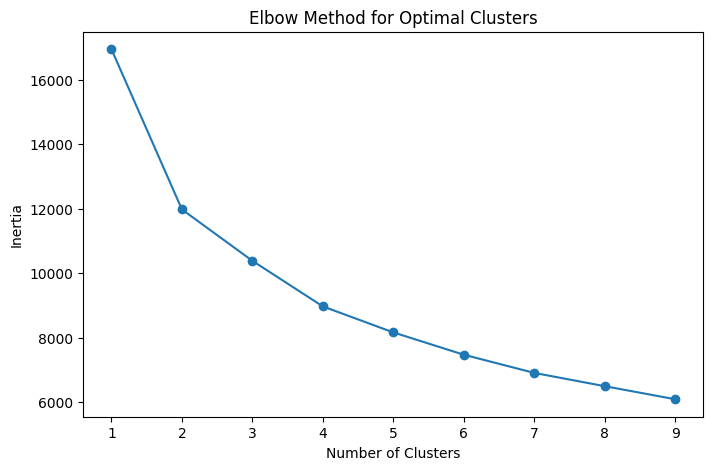

In [ ]:
from sklearn.preprocessing import StandardScaler
df = df.dropna()
# Select features to use for clustering
features = [
    'count', 'AWND', 'PRCP', 'SNOW', 'TAVG', 'TMAX', 'TMIN', 'temp_range',
    'incidents_per_station', 'delays_per_incident', 'ridership'
]

# Scale the selected features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

# Create a DataFrame for scaled features
scaled_df = pd.DataFrame(scaled_features, columns=features)


from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determine optimal number of clusters using the elbow method
inertia = []
range_clusters = range(1, 10)
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range_clusters, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

# Apply K-Means with the optimal number of clusters
optimal_k = 4  # Replace this with the number of clusters you choose from the elbow method
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(scaled_features)

            count       AWND       PRCP       SNOW       TAVG       TMAX  \
cluster                                                                    
0        2.807229   8.986687  16.317470   3.159036  56.105823  63.604769   
1        1.137143   9.891803  15.205371   3.980190  44.724898  51.874930   
2        1.182171   8.087939  18.421137   0.000000  71.040829  78.806286   
3        1.320000  10.477000  17.166267  74.724000  34.642667  40.676000   

              TMIN  temp_range  incidents_per_station  delays_per_incident  \
cluster                                                                      
0        48.612570   14.992199               0.095348           860.485542   
1        37.576451   14.298479               0.033044          1922.787619   
2        63.282179   15.524106               0.034743          1880.802756   
3        28.625667   12.050333               0.041791          1458.660000   

            ridership  
cluster                
0        8.620093e+07  
1 

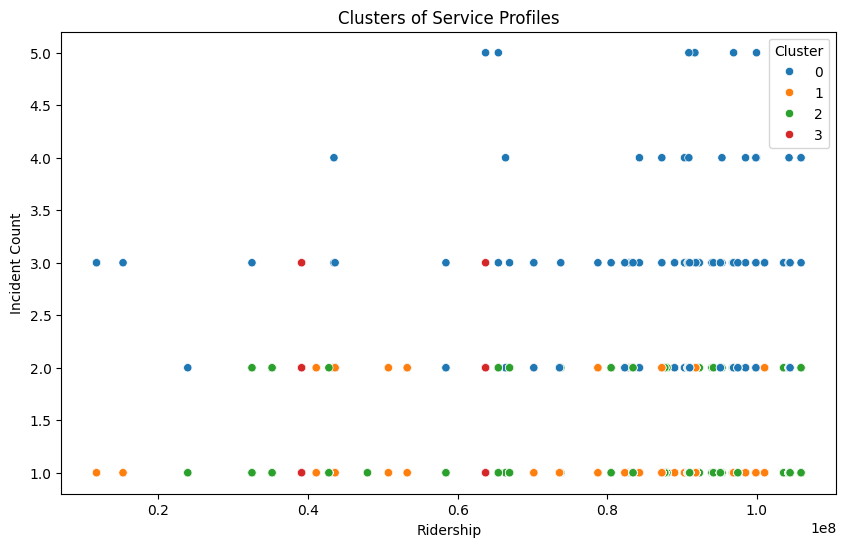

In [ ]:
cluster_profiles = df.groupby('cluster')[features].mean()
print(cluster_profiles)

import seaborn as sns

# Plot ridership vs. incident count by cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='ridership', y='count', hue='cluster', palette='tab10')
plt.title("Clusters of Service Profiles")
plt.xlabel("Ridership")
plt.ylabel("Incident Count")
plt.legend(title="Cluster")
plt.show()


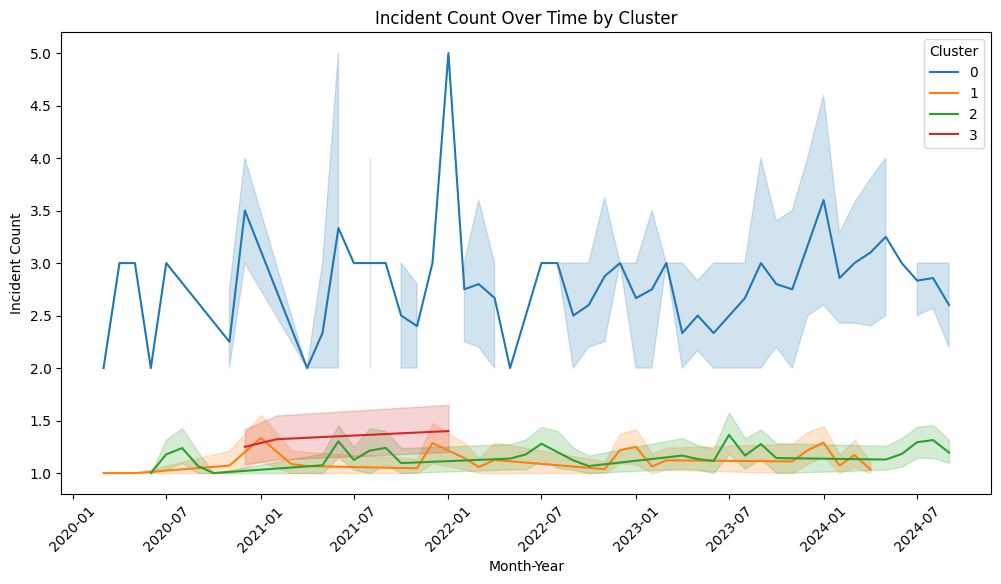

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='month_yr', y='count', hue='cluster', palette='tab10')
plt.title("Incident Count Over Time by Cluster")
plt.xlabel("Month-Year")
plt.ylabel("Incident Count")
plt.xticks(rotation=45)
plt.legend(title="Cluster")
plt.show()


# <font color=green> Clustering



#Cluster 1: Line, day_type, count, year, and category


In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

clustering_v1 = df_preprocess.groupby(['line', 'day_type', 'year', 'category'])['count'].sum().reset_index()

# Assuming df_preprocess is already loaded
# Select relevant columns for clustering
#df_clustering = df_preprocess[['line', 'day_type', 'count', 'year', 'category']]
df_clustering = clustering_v1

# One-Hot Encode categorical variables (line, category)
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(df_clustering[['line', 'category']])

# Convert the encoded arrays into DataFrames with appropriate column names
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['line', 'category']))

# Reset index of the DataFrames before concatenation to ensure proper alignment
encoded_df.reset_index(drop=True, inplace=True)
df_clustering.reset_index(drop=True, inplace=True)

# Combine the encoded DataFrames with the numerical columns (day_type, count, year)
df_combined = pd.concat([encoded_df, df_clustering[['day_type', 'count', 'year']]], axis=1)

# Scale the data (important for distance-based algorithms like KMeans)
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_combined)

# Apply PCA for dimensionality reduction (2 components for visualization)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_df)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])

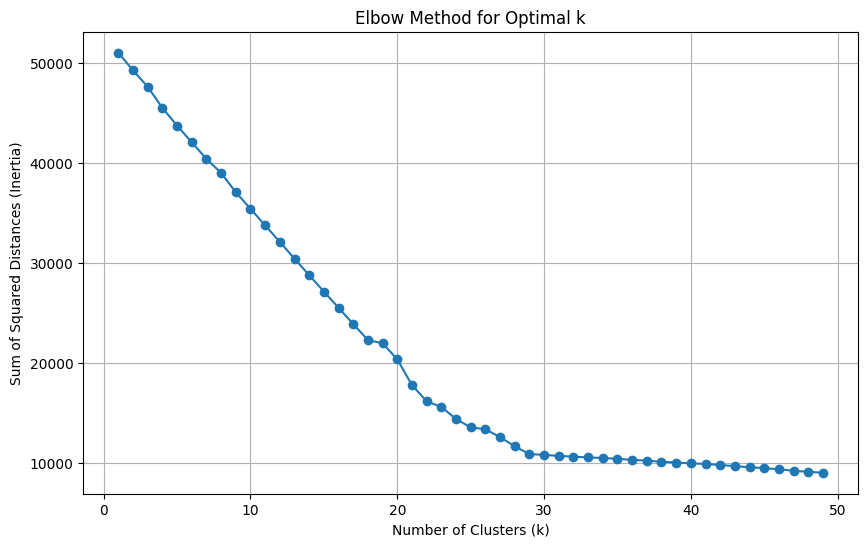

Silhouette Score for k=20: 0.385
Silhouette Score for k=21: 0.444
Silhouette Score for k=22: 0.458
Silhouette Score for k=23: 0.467
Silhouette Score for k=24: 0.419
Silhouette Score for k=25: 0.426
Silhouette Score for k=26: 0.417
Silhouette Score for k=27: 0.375
Silhouette Score for k=28: 0.411
Silhouette Score for k=29: 0.356


In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Calculate the sum of squared distances for different values of k
ssd = []  # Sum of Squared Distances

# Trying different values for the number of clusters
K = range(1, 50)  # Typically, you try values from 1 to 10 or more

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)  # Use the scaled data for clustering
    ssd.append(kmeans.inertia_)  # Append the inertia (sum of squared distances) to the list

# Plot the SSDs against the number of clusters
plt.figure(figsize=(10, 6))
plt.plot(K, ssd, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

from sklearn.metrics import silhouette_score

# Define a range for the number of clusters around the elbow point
cluster_range = np.arange(20, 30, 1)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_df)
    silhouette_avg = silhouette_score(scaled_df, cluster_labels)
    print(f'Silhouette Score for k={k}: {silhouette_avg:.3f}')

<ipython-input-22-8d1394c3fc84>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', 21)  # Use a colormap that can accommodate many clusters


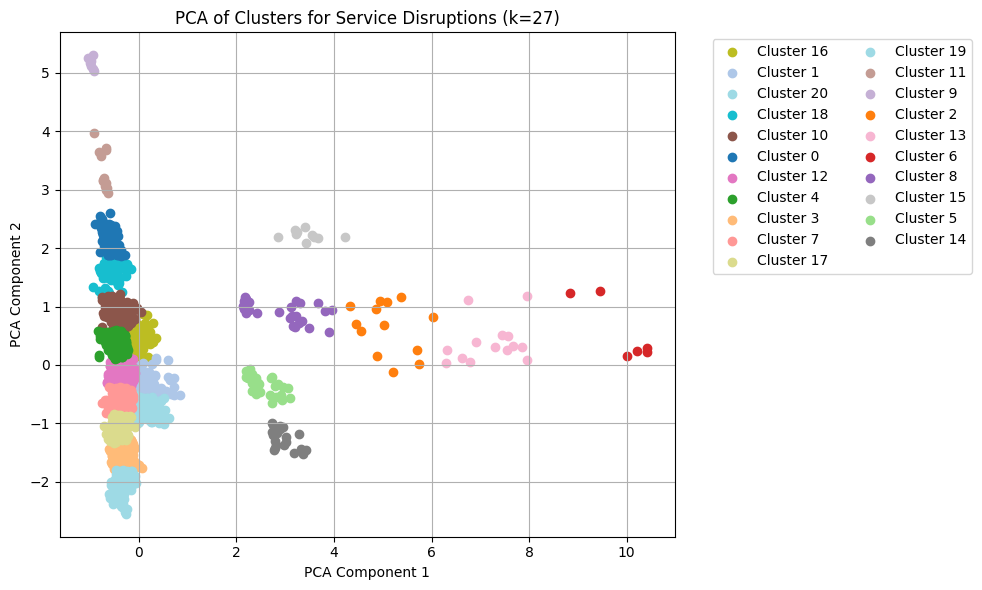

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Apply KMeans clustering with 27 clusters
kmeans = KMeans(n_clusters=21, random_state=42)
pca_df['cluster'] = kmeans.fit_predict(pca_components)

# Plot the PCA results with cluster assignments
plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap('tab20', 21)  # Use a colormap that can accommodate many clusters

for cluster in pca_df['cluster'].unique():
    cluster_data = pca_df[pca_df['cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}', color=colors(cluster))

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Clusters for Service Disruptions (k=27)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)  # Adjust legend to fit many clusters
plt.grid(True)
plt.tight_layout()
plt.show()


#Cluster 2: day_type, season, period, line, service category disruption

In [ ]:
def determine_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Apply the function to create the 'season' column
df_preprocess['season'] = df_preprocess['month'].apply(determine_season)
df_preprocess

month    division        line  day_type  \
0         1  A DIVISION           1         1   
35        1  B DIVISION           C         1   
36        1  B DIVISION           C         1   
37        1  B DIVISION           D         1   
38        1  B DIVISION           D         2   
39        1  B DIVISION           E         1   
40        1  B DIVISION           E         1   
41        1  B DIVISION           F         1   
42        1  B DIVISION           F         1   
43        1  B DIVISION           F         1   
44        1  B DIVISION          JZ         1   
45        1  B DIVISION           M         1   
46        1  B DIVISION           M         1   
47        1  B DIVISION           M         1   
49        1  B DIVISION           N         1   
34        1  B DIVISION           C         1   
50        1  B DIVISION           N         1   
52        1  B DIVISION           Q         1   
53        1  B DIVISION           Q         1   
54        1  B DIVISION           R         1   
55        1  B DIVISION           R         1   
56        1  B DIVISION           R         2   
57        1  Systemwide  Systemwide         1   
58        1  Systemwide  Systemwide         1   
59        1  Systemwide  Systemwide         1   
60        1  Systemwide  Systemwide         1   
61        1  Systemwide  Systemwide         1   
62        1  Systemwide  Systemwide         1   
63        1  Systemwide  Systemwide         2   
64        1  Systemwide  Systemwide         2   
65        1  Systemwide  Systemwide         2   
51        1  B DIVISION           Q         1   
33        1  B DIVISION           B         1   
48        1  B DIVISION           N         1   
31        1  B DIVISION           A         1   
32        1  B DIVISION           A         1   
2         1  A DIVISION           1         2   
3         1  A DIVISION           2         1   
4         1  A DIVISION           2         1   
5         1  A DIVISION           2         1   
6         1  A DIVISION           2         1   
7         1  A DIVISION           2         2   
8         1  A DIVISION           3         1   
9         1  A DIVISION           3         1   
10        1  A DIVISION           3         2   
11        1  A DIVISION           3         2   
12        1  A DIVISION           4         1   
13        1  A DIVISION           4         1   
14        1  A DIVISION           4         1   
15        1  A DIVISION           4         1   
1         1  A DIVISION           1         1   
17        1  A DIVISION           5         1   
16        1  A DIVISION           5         1   
29        1  B DIVISION           A         1   
28        1  A DIVISION           7         2   
27        1  A DIVISION           7         1   
26        1  A DIVISION           6         2   
25        1  A DIVISION           6         1   
24        1  A DIVISION           6         1   
30        1  B DIVISION           A         1   
22        1  A DIVISION           6         1   
21        1  A DIVISION           5         2   
20        1  A DIVISION           5         1   
19        1  A DIVISION           5         1   
18        1  A DIVISION           5         1   
23        1  A DIVISION           6         1   
111       2  B DIVISION           N         1   
110       2  B DIVISION           N         1   
109       2  B DIVISION           M         1   
108       2  B DIVISION           M         1   
99        2  B DIVISION           E         2   
107       2  B DIVISION           M         1   
103       2  B DIVISION          JZ         1   
105       2  B DIVISION           L         1   
102       2  B DIVISION           G         1   
101       2  B DIVISION           F         1   
100       2  B DIVISION           F         1   
112       2  B DIVISION           N         1   
106       2  B DIVISION           L         1   
113       2  B DIVISION           N         2   
121       2  Systemwide  Systemwide  

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

clustering_v2 = df_preprocess.groupby(['line', 'day_type', 'period', 'category', 'season'])['count'].sum().reset_index()

# Select relevant columns for clustering
df_clustering = clustering_v2

# One-Hot Encode all categorical variables (line, category, period, season)
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_features = encoder.fit_transform(df_clustering[['line', 'category', 'period', 'season']])

# Convert the encoded arrays into DataFrames with appropriate column names
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['line', 'category', 'period', 'season']))

# Reset index of the DataFrames before concatenation to ensure proper alignment
encoded_df.reset_index(drop=True, inplace=True)
df_clustering.reset_index(drop=True, inplace=True)

# Combine the encoded DataFrames with the numerical columns (day_type, count)
df_combined = pd.concat([encoded_df, df_clustering[['day_type', 'count']]], axis=1)

# Scale the data (important for distance-based algorithms like KMeans)
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df_combined)

# Apply PCA for dimensionality reduction (2 components for visualization)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_df)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])


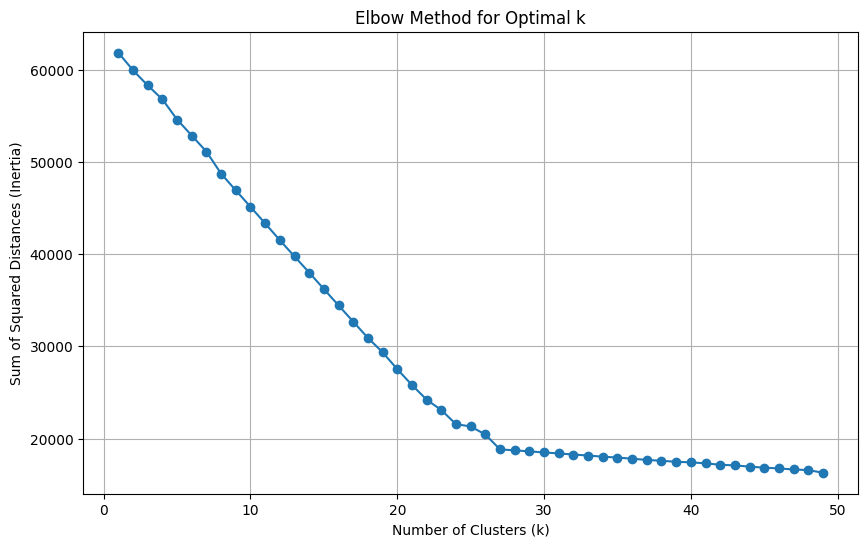

Silhouette Score for k=20: 0.344
Silhouette Score for k=21: 0.356
Silhouette Score for k=22: 0.373
Silhouette Score for k=23: 0.386
Silhouette Score for k=24: 0.359
Silhouette Score for k=25: 0.342
Silhouette Score for k=26: 0.305
Silhouette Score for k=27: 0.294
Silhouette Score for k=28: 0.285
Silhouette Score for k=29: 0.262


In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Calculate the sum of squared distances for different values of k
ssd = []  # Sum of Squared Distances

# Trying different values for the number of clusters
K = range(1, 50)  # Typically, you try values from 1 to 10 or more

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)  # Use the scaled data for clustering
    ssd.append(kmeans.inertia_)  # Append the inertia (sum of squared distances) to the list

# Plot the SSDs against the number of clusters
plt.figure(figsize=(10, 6))
plt.plot(K, ssd, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

from sklearn.metrics import silhouette_score

# Define a range for the number of clusters around the elbow point
cluster_range = np.arange(20, 30, 1)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_df)
    silhouette_avg = silhouette_score(scaled_df, cluster_labels)
    print(f'Silhouette Score for k={k}: {silhouette_avg:.3f}')

<ipython-input-26-9e65b299ea64>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', 23)  # Use a colormap that can accommodate many clusters


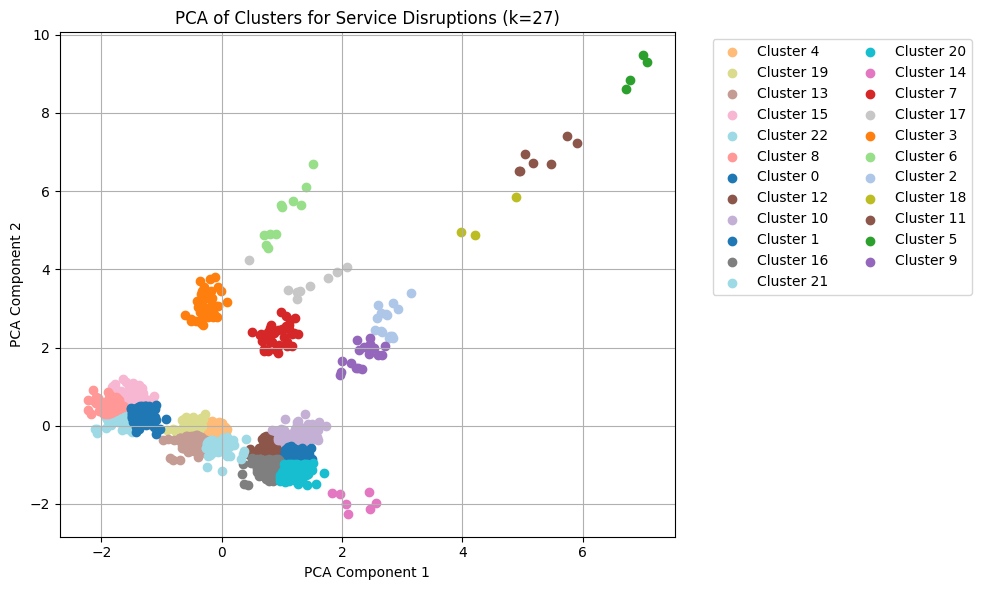

In [ ]:

# Apply KMeans clustering (adjusted for 27 clusters based on previous analysis)
kmeans = KMeans(n_clusters=23, random_state=42)
pca_df['cluster'] = kmeans.fit_predict(pca_components)

# Plot the PCA results with cluster assignments
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
colors = plt.cm.get_cmap('tab20', 23)  # Use a colormap that can accommodate many clusters

for cluster in pca_df['cluster'].unique():
    cluster_data = pca_df[pca_df['cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}', color=colors(cluster))

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Clusters for Service Disruptions (k=27)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)  # Adjust legend to fit many clusters
plt.grid(True)
plt.tight_layout()
plt.show()

#Profiles of clusters

In [ ]:
clustering_v2['cluster'] = kmeans.labels_
clustering_v2.head()

line  day_type                period                            category  \
0    1         1  Pandemic (2020-2021)                               Other   
1    1         1  Pandemic (2020-2021)                               Other   
2    1         1  Pandemic (2020-2021)  Persons on Trackbed/Police/Medical   
3    1         1  Pandemic (2020-2021)  Persons on Trackbed/Police/Medical   
4    1         1  Pandemic (2020-2021)  Persons on Trackbed/Police/Medical   

   season  count  cluster  
0  Summer      1        4  
1  Winter      3        4  
2    Fall      5       19  
3  Spring      3       19  
4  Summer      1       19

In [ ]:
# Create a new DataFrame that includes the original features along with the assigned cluster labels
df_with_clusters = clustering_v2

# Group by 'cluster' and calculate summary statistics for each group
cluster_summary = df_with_clusters.groupby('cluster').agg({
    'count': ['mean', 'sum'],                 # Mean and sum of service disruptions for each cluster
    'day_type': 'mean',                       # Average value to understand the ratio of weekdays vs weekends
    'category': lambda x: x.mode()[0],        # Most common category of service disruption for each cluster
    'line': lambda x: x.mode()[0],            # Most common subway line for each cluster
    'season': lambda x: x.mode()[0],          # Most common season for each cluster
    'period': lambda x: x.mode()[0]           # Most common period (Pre-Pandemic, Pandemic, Post-Pandemic)
})

# Rename columns for better readability
cluster_summary.columns = [
    'Average Count of Disruptions', 'Total Count of Disruptions', 'Average Day Type (Weekday=1)',
    'Most Common Category', 'Most Common Line', 'Most Common Season', 'Most Common Period'
]

# Display the cluster summary
print("Cluster Summary Statistics:")
print(cluster_summary)


Cluster Summary Statistics:
         Average Count of Disruptions  Total Count of Disruptions  \
cluster                                                             
0                            2.141667                         257   
1                            6.088050                         968   
2                           49.933333                         749   
3                           14.055556                         506   
4                            2.686441                         317   
5                          302.500000                        1210   
6                          100.181818                        1102   
7                            9.128205                         356   
8                            2.960000                         296   
9                           15.111111                         272   
10                          19.057471                        1658   
11                         216.000000                        1512   
12    

#Misc.

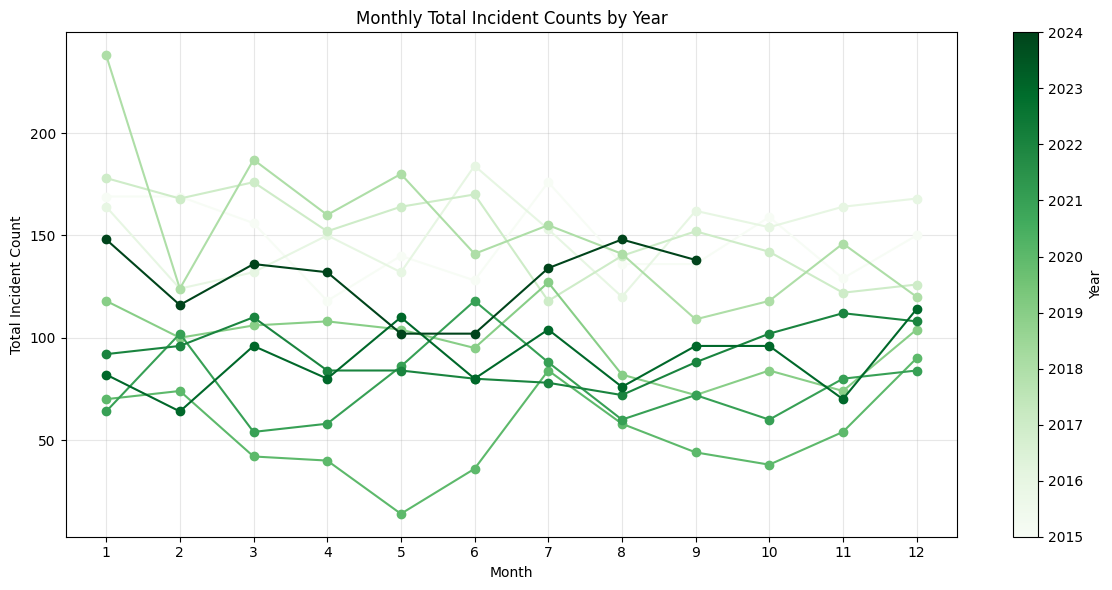

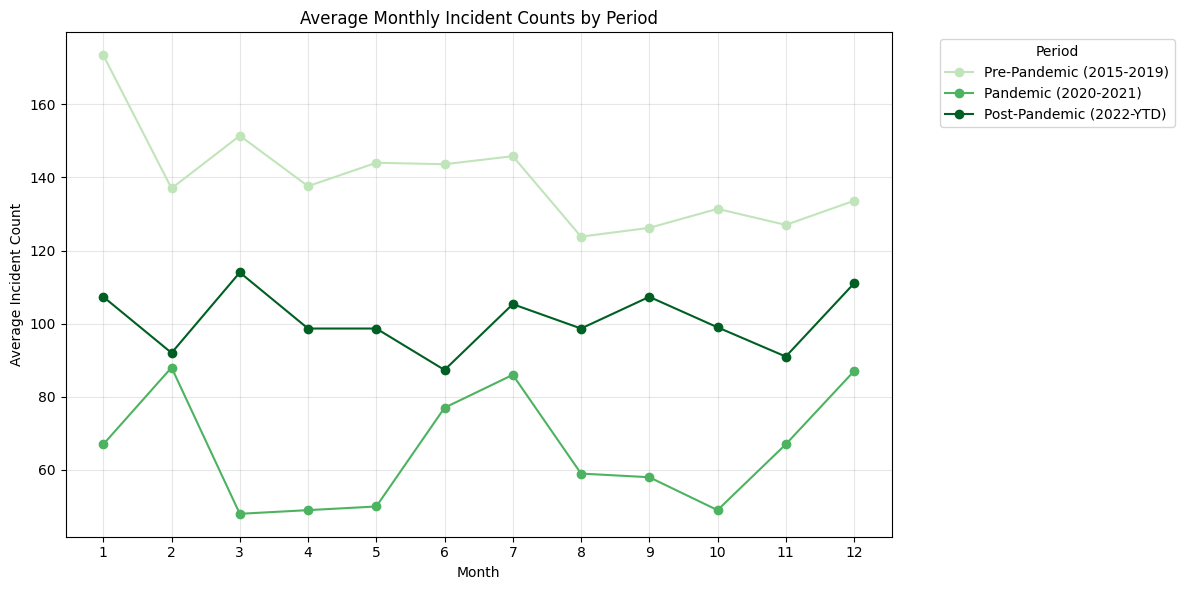

In [ ]:
#Visual1
monthly_totals = df_preprocess.groupby(['year', 'month'])['count'].sum().reset_index()
monthly_totals = monthly_totals.sort_values(['year', 'month'])

fig, ax = plt.subplots(figsize=(12, 6))
cmap = cm.Greens
norm = plt.Normalize(vmin=monthly_totals['year'].min(), vmax=monthly_totals['year'].max())

for year in sorted(monthly_totals['year'].unique()):
    year_data = monthly_totals[monthly_totals['year'] == year]
    ax.plot(year_data['month'], year_data['count'], marker='o',
             color=cmap(norm(year)))

ax.set_title('Monthly Total Incident Counts by Year')
ax.set_xlabel('Month')
ax.set_ylabel('Total Incident Count')
ax.set_xticks(range(1, 13))
ax.grid(True, alpha=0.3)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Year')
plt.tight_layout()
plt.show()

#Visual2

monthly_totals = df_preprocess.groupby(['year', 'month'])['count'].sum().reset_index()

def categorize_period(year):
    if year < 2020:
        return 'Pre-Pandemic (2015-2019)'
    elif year == 2020 or year == 2021:
        return 'Pandemic (2020-2021)'
    elif year >= 2022:
        return 'Post-Pandemic (2022-YTD)'

monthly_totals['period'] = monthly_totals['year'].apply(categorize_period)
period_avg = monthly_totals.groupby(['month', 'period'])['count'].mean().unstack()

color_map = {
    'Pre-Pandemic (2015-2019)': '#c1e5ba',
    'Pandemic (2020-2021)': '#4db361',
    'Post-Pandemic (2022-YTD)': '#005f22'
}

plt.figure(figsize=(12, 6))
for period in period_avg.columns:
    plt.plot(period_avg.index, period_avg[period], marker='o', label=period, color=color_map[period])


plt.title('Average Monthly Incident Counts by Period')
plt.xlabel('Month')
plt.ylabel('Average Incident Count')
plt.xticks(range(1, 13))
plt.grid(True, alpha=0.3)

handles, labels = plt.gca().get_legend_handles_labels()
order = ['Pre-Pandemic (2015-2019)', 'Pandemic (2020-2021)', 'Post-Pandemic (2022-YTD)']
plt.legend([handles[labels.index(o)] for o in order], order, title='Period', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
#One hot encoding

from sklearn.preprocessing import OneHotEncoder, StandardScaler

#Dropping division column
df_preprocess = df_preprocess.drop(columns={'division'})

#day type (weekend vs weekday) --> binary
df_preprocess['day_type'] = df_preprocess['day_type'].apply(lambda x: 1 if x == 2 else 0)

# Normalize the numerical features: 'count'
scaler = StandardScaler()
df_preprocess['count'] = scaler.fit_transform(df_preprocess[['count']])

#one hot encode --> categorical variables
df_preprocess_ohe = pd.get_dummies(df_preprocess, columns=['line', 'category'],
                               drop_first=True)

#Initial plan

##Experiment

**Main Prediction**

Step 1: Preprocess data

Step 2: Visualize

Step 3: Apply log reg model

##Side Experiments

**Experiment 1: Correlation between major incidents and time (Visualization)**

*   Assess seasons?
*   Pre and post-pandemic patterns across service delays and lines

**Experiment 2: Age of Line (Merge)**

**Experiment 3:  Clustering**
- unsupervised learning
- no target variable

Assess correlation between feature vectors and target variable (count of incidents)